-------------------------------------------------

=== Análisis para ESPADA ===
Tasa de deserción en ESPADA: 56.08%
Edad promedio de deserción: 24.5 años
Costo promedio (Licencia + Inscripción): $327,152
Deserción por género:
 genero
FEMENINO     0.552632
MASCULINO    0.565934
Name: deserto, dtype: float64 



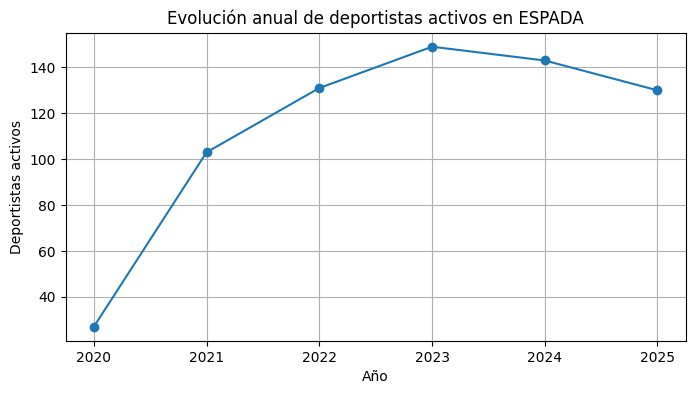


=== Análisis para FLORETE ===
Tasa de deserción en FLORETE: 60.70%
Edad promedio de deserción: 23.2 años
Costo promedio (Licencia + Inscripción): $318,414
Deserción por género:
 genero
FEMENINO     0.647727
MASCULINO    0.575221
Name: deserto, dtype: float64 



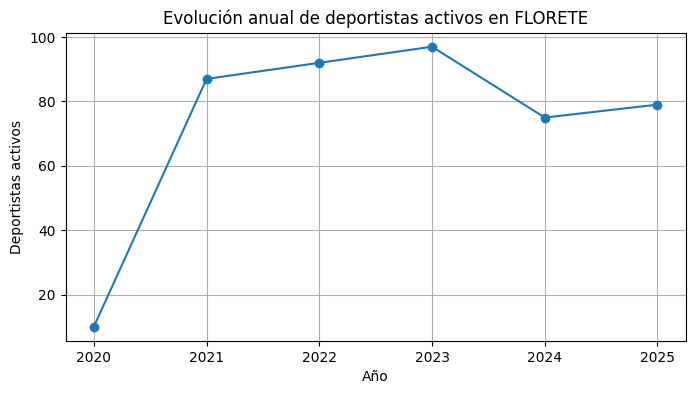


=== Análisis para SABLE ===
Tasa de deserción en SABLE: 61.11%
Edad promedio de deserción: 21.4 años
Costo promedio (Licencia + Inscripción): $323,698
Deserción por género:
 genero
FEMENINO     0.643478
MASCULINO    0.579832
Name: deserto, dtype: float64 



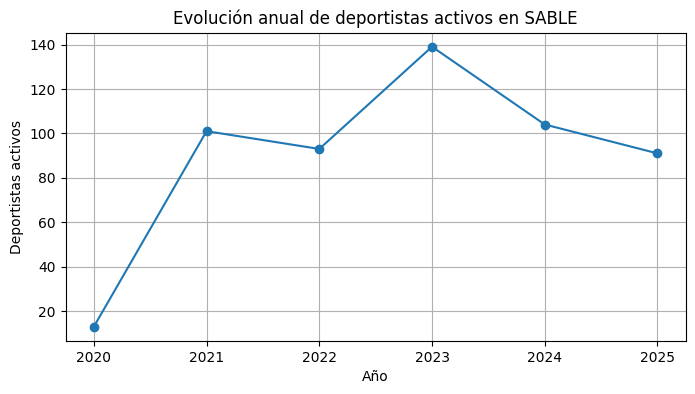

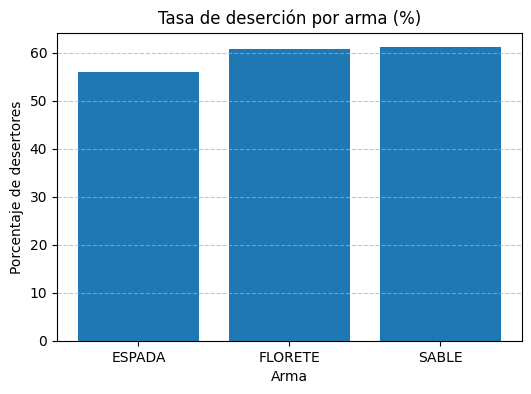


=== IMPACTO ECONÓMICO REAL ===
Dinero perdido total ajustado: $292,549,100

=== CORRELACIÓN ENTRE COSTOS Y DESERCIÓN ===
Correlación costo licencia vs deserción: -0.674
Correlación costo inscripción vs deserción: -0.630


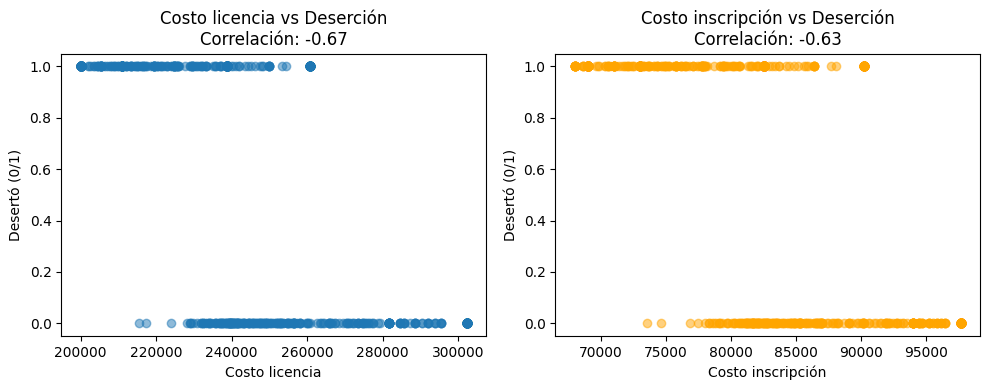

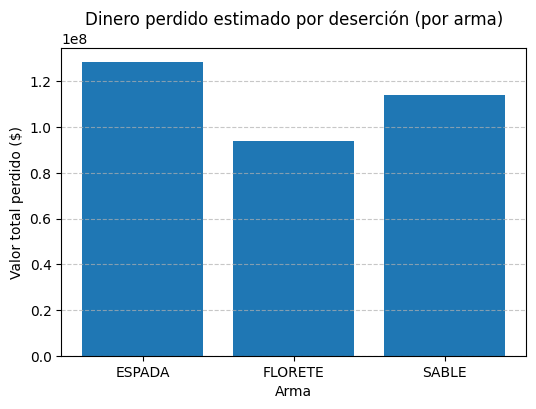

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery

client = bigquery.Client()

# === 1. Consulta SQL actualizada ===
query = """
SELECT
  r.`Nombre`,
  r.`Liga`,
  r.`Club`,
  r.`Posición` AS Posicion,
  r.`Puntos`,
  r.`prueba_id`,
  r.`Titulo`,
  r.`Fecha`,
  r.`Categoria`,
  r.`Arma`,
  r.`Genero`,
  r.`Tipo`,
  f.`Fecha de nacimiento` AS Fecha_Nacimiento,
  c.`Costo Licencia` AS Costo_Licencia,
  c.`Costo Inscripcion` AS Costo_Inscripcion
FROM `instant-bonbon-474722-g7.Resultados_Pruebas_Mayores.Resultados Pruebas Categorías Mayores` AS r
LEFT JOIN `instant-bonbon-474722-g7.Resultados_Pruebas_Mayores.Fechas_Nacimiento` AS f
  ON TRIM(LOWER(r.`Nombre`)) = TRIM(LOWER(f.`Nombre`))
LEFT JOIN `instant-bonbon-474722-g7.Resultados_Pruebas_Mayores.Costos_Anuales` AS c
  ON EXTRACT(YEAR FROM r.`Fecha`) = c.`Año`
"""

print("-------------------------------------------------")
df = client.query(query).to_dataframe()

# === 2. Limpieza y preparación ===
df = df.rename(columns=lambda x: x.strip().lower())
df = df.drop(columns=[c for c in df.columns if 'unnamed' in c.lower()], errors='ignore')

# Convertir fechas
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df['fecha_nacimiento'] = pd.to_datetime(df['fecha_nacimiento'], errors='coerce', dayfirst=True)
df['año'] = df['fecha'].dt.year

# Calcular edad al momento de la competencia
df['edad'] = (df['fecha'] - df['fecha_nacimiento']).dt.days / 365.25

# Eliminar duplicados
df = df.drop_duplicates(subset=['nombre', 'prueba_id', 'arma'])

# === 3. Análisis por arma ===
resultados = []

for arma, datos_arma in df.groupby('arma'):
    print(f"\n=== Análisis para {arma.upper()} ===")

    max_año = datos_arma['año'].max()
    ultima_por_deportista = datos_arma.groupby('nombre')['año'].max().reset_index()
    ultima_por_deportista['deserto'] = (max_año - ultima_por_deportista['año']) >= 1

    perfil = datos_arma.groupby('nombre').agg({
        'puntos': 'mean',
        'posicion': 'mean',
        'prueba_id': 'count',
        'categoria': 'first',
        'genero': 'first',
        'fecha_nacimiento': 'first',
        'costo_licencia': 'mean',
        'costo_inscripcion': 'mean',
        'edad': 'mean'
    }).reset_index()

    analisis = perfil.merge(ultima_por_deportista[['nombre', 'año', 'deserto']], on='nombre')

    # === 4. Cálculos adicionales por arma ===
    tasa = analisis['deserto'].mean()
    edad_desercion_prom = analisis.loc[analisis['deserto'], 'edad'].mean()
    costo_prom_lic = analisis['costo_licencia'].mean()
    costo_prom_insc = analisis['costo_inscripcion'].mean()

    print(f"Tasa de deserción en {arma}: {tasa:.2%}")
    print(f"Edad promedio de deserción: {edad_desercion_prom:.1f} años")
    print(f"Costo promedio (Licencia + Inscripción): ${costo_prom_lic + costo_prom_insc:,.0f}")
    print("Deserción por género:\n", analisis.groupby('genero')['deserto'].mean(), "\n")

    resultados.append(analisis.assign(arma=arma))

    # === 5. Gráfico de participación anual ===
    activos_anuales = datos_arma.groupby('año')['nombre'].nunique().reset_index()
    plt.figure(figsize=(8, 4))
    plt.plot(activos_anuales['año'], activos_anuales['nombre'], marker='o')
    plt.title(f'Evolución anual de deportistas activos en {arma}')
    plt.xlabel('Año')
    plt.ylabel('Deportistas activos')
    plt.grid(True)
    plt.show()

# === 6. Resultados combinados ===
analisis_total = pd.concat(resultados, ignore_index=True)

# === 7. Tasa de deserción por arma ===
tasa_por_arma = analisis_total.groupby('arma')['deserto'].mean().reset_index()

plt.figure(figsize=(6,4))
plt.bar(tasa_por_arma['arma'], tasa_por_arma['deserto']*100)
plt.title('Tasa de deserción por arma (%)')
plt.ylabel('Porcentaje de desertores')
plt.xlabel('Arma')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# === 8. Ajuste económico: evitar duplicar licencias ===
# Solo una licencia por deportista y año
licencias_unicas = (
    df[['nombre', 'año', 'costo_licencia']]
    .drop_duplicates(subset=['nombre', 'año'])
)

# Desertores
desertores = analisis_total.loc[analisis_total['deserto']].copy()

# Licencias únicas por desertores
licencias_desertores = (
    licencias_unicas[licencias_unicas['nombre'].isin(desertores['nombre'])]
    ['costo_licencia']
    .sum()
)

# Inscripciones sí se pagan por evento
inscripciones_desertores = df[df['nombre'].isin(desertores['nombre'])]['costo_inscripcion'].sum()

# Pérdida económica real
dinero_perdido_real = licencias_desertores + inscripciones_desertores

print("\n=== IMPACTO ECONÓMICO REAL ===")
print(f"Dinero perdido total ajustado: ${dinero_perdido_real:,.0f}")

# === 9. Correlación entre costos y deserción ===
corr_lic = analisis_total[['costo_licencia', 'deserto']].corr().iloc[0, 1]
corr_insc = analisis_total[['costo_inscripcion', 'deserto']].corr().iloc[0, 1]

print("\n=== CORRELACIÓN ENTRE COSTOS Y DESERCIÓN ===")
print(f"Correlación costo licencia vs deserción: {corr_lic:.3f}")
print(f"Correlación costo inscripción vs deserción: {corr_insc:.3f}")

#Graficos Correlaiones
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Scatter: deserción vs costo licencia
axes[0].scatter(analisis_total['costo_licencia'], analisis_total['deserto'], alpha=0.5)
axes[0].set_title(f"Costo licencia vs Deserción\nCorrelación: {corr_lic:.2f}")
axes[0].set_xlabel("Costo licencia")
axes[0].set_ylabel("Desertó (0/1)")

# Scatter: deserción vs costo inscripción
axes[1].scatter(analisis_total['costo_inscripcion'], analisis_total['deserto'], alpha=0.5, color='orange')
axes[1].set_title(f"Costo inscripción vs Deserción\nCorrelación: {corr_insc:.2f}")
axes[1].set_xlabel("Costo inscripción")
axes[1].set_ylabel("Desertó (0/1)")

plt.tight_layout()
plt.show()

# === 10. Visualización del dinero perdido por arma ===
dinero_perdido_por_arma = (
    df[df['nombre'].isin(desertores['nombre'])]
    .groupby('arma')[['costo_inscripcion']]
    .sum()
    .reset_index()
)

# Agregar licencias únicas (una por deportista y año)
licencias_desertores_por_arma = (
    licencias_unicas[licencias_unicas['nombre'].isin(desertores['nombre'])]
    .merge(df[['nombre', 'arma']].drop_duplicates(), on='nombre', how='left')
    .groupby('arma')['costo_licencia']
    .sum()
    .reset_index()
)

# Combinar ambos
dinero_perdido_por_arma = dinero_perdido_por_arma.merge(
    licencias_desertores_por_arma, on='arma', how='left'
)
dinero_perdido_por_arma['dinero_perdido'] = (
    dinero_perdido_por_arma['costo_inscripcion'] + dinero_perdido_por_arma['costo_licencia']
)

plt.figure(figsize=(6,4))
plt.bar(dinero_perdido_por_arma['arma'], dinero_perdido_por_arma['dinero_perdido'])
plt.title('Dinero perdido estimado por deserción (por arma)')
plt.ylabel('Valor total perdido ($)')
plt.xlabel('Arma')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


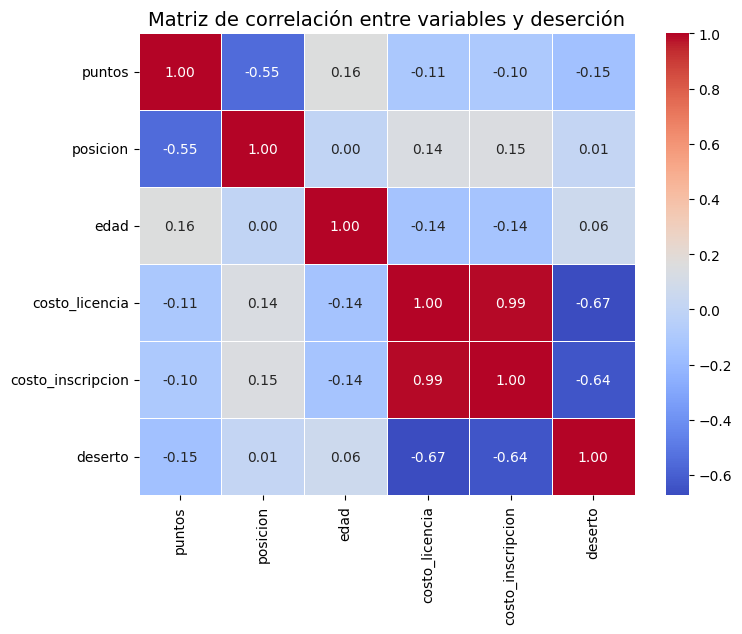

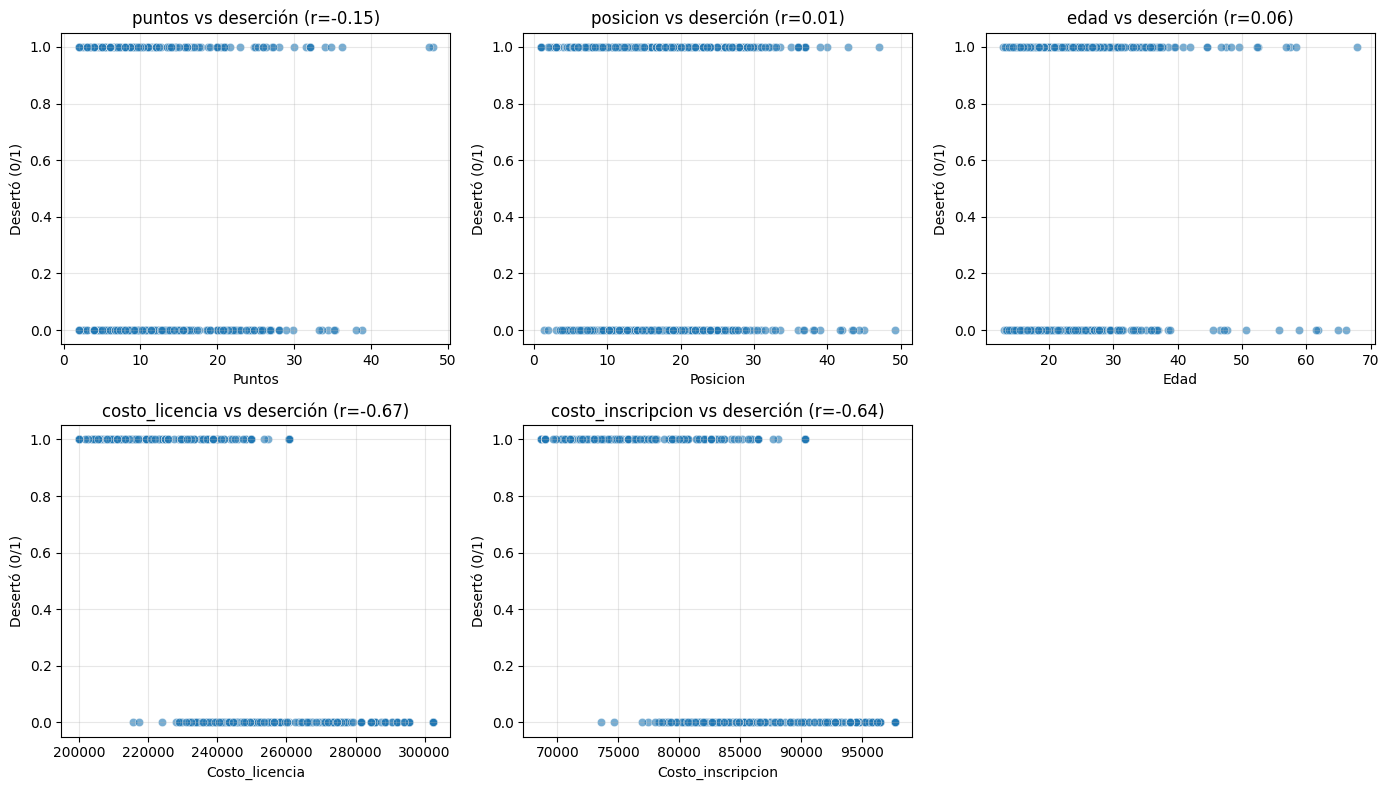


=== INTERPRETACIÓN RÁPIDA ===
Valores de correlación con la variable 'deserto':
deserto              1.000000
edad                 0.061968
posicion             0.014135
puntos              -0.154462
costo_inscripcion   -0.635184
costo_licencia      -0.673803
Name: deserto, dtype: float64

➡ Correlaciones positivas indican que a mayor valor de la variable,
   aumenta la probabilidad de deserción (por ejemplo, mayor costo o mayor edad).
➡ Correlaciones negativas indican que a mayor valor, menor probabilidad de deserción
   (por ejemplo, más puntos o mejor posición pueden asociarse con permanencia).



In [14]:
# === 11. Correlaciones adicionales con la variable de deserción ===
import seaborn as sns
# Seleccionamos las variables numéricas relevantes del análisis total
variables_numericas = [
    'puntos', 'posicion', 'edad', 'costo_licencia', 'costo_inscripcion'
]

# Filtramos las columnas que existen en analisis_total y que no tienen nulos
df_corr = analisis_total[[v for v in variables_numericas if v in analisis_total.columns] + ['deserto']].dropna()

# === 11.1. Matriz de correlación (Pearson) ===
corr_matrix = df_corr.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5
)
plt.title("Matriz de correlación entre variables y deserción", fontsize=14)
plt.show()

# === 11.2. Scatterplots individuales vs deserción ===
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(variables_numericas):
    sns.scatterplot(
        data=df_corr,
        x=col,
        y='deserto',
        alpha=0.6,
        ax=axes[i]
    )
    corr_value = df_corr[[col, 'deserto']].corr().iloc[0, 1]
    axes[i].set_title(f"{col} vs deserción (r={corr_value:.2f})")
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel("Desertó (0/1)")
    axes[i].grid(alpha=0.3)

# Elimina posibles ejes vacíos si hay menos de 6 gráficas
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# === 11.3. Interpretación general (opcional, resumen automático) ===
print("\n=== INTERPRETACIÓN RÁPIDA ===")
print("Valores de correlación con la variable 'deserto':")
print(corr_matrix['deserto'].sort_values(ascending=False))

print("""
➡ Correlaciones positivas indican que a mayor valor de la variable,
   aumenta la probabilidad de deserción (por ejemplo, mayor costo o mayor edad).
➡ Correlaciones negativas indican que a mayor valor, menor probabilidad de deserción
   (por ejemplo, más puntos o mejor posición pueden asociarse con permanencia).
""")



=== ANÁLISIS POR LIGA ===

=== Liga: ANTIOQUIA ===
Tasa de deserción en ANTIOQUIA: 52.86%
Edad promedio de deserción: 26.0 años
Costo promedio (Licencia + Inscripción): $319,068
Deserción por género:
 genero
FEMENINO     0.516129
MASCULINO    0.538462
Name: deserto, dtype: float64 


=== Liga: ATLANTICO ===
Tasa de deserción en ATLANTICO: 0.00%
Edad promedio de deserción: nan años
Costo promedio (Licencia + Inscripción): $315,083
Deserción por género:
 genero
FEMENINO     0.0
MASCULINO    0.0
Name: deserto, dtype: float64 


=== Liga: BOGOTA ===
Tasa de deserción en BOGOTA: 49.59%
Edad promedio de deserción: 25.2 años
Costo promedio (Licencia + Inscripción): $327,093
Deserción por género:
 genero
FEMENINO     0.425926
MASCULINO    0.550725
Name: deserto, dtype: float64 


=== Liga: CALDAS ===
Tasa de deserción en CALDAS: 56.25%
Edad promedio de deserción: 20.7 años
Costo promedio (Licencia + Inscripción): $315,430
Deserción por género:
 genero
FEMENINO     0.833333
MASCULINO    0.4000

/tmp/ipython-input-1996744073.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tasa_por_liga, x='liga', y='deserto', palette='crest')


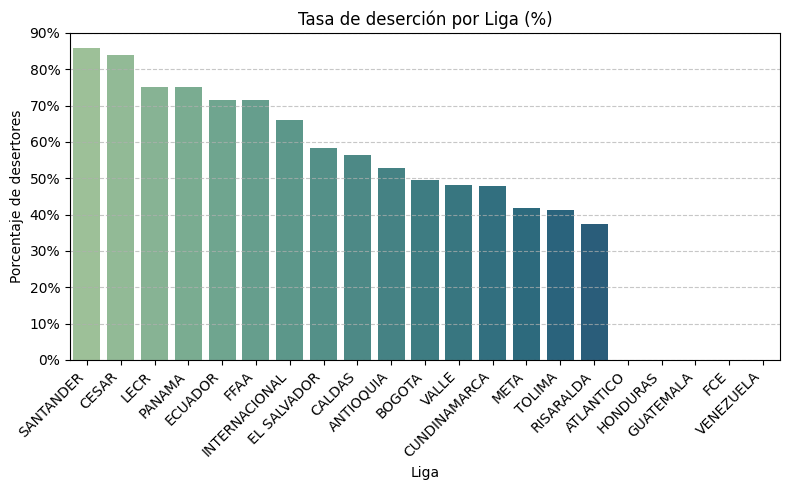

/tmp/ipython-input-1996744073.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calcular_corr)



Vista previa de las correlaciones por liga:
        liga variable  correlacion
0  ANTIOQUIA   puntos    -0.409796
1  ATLANTICO   puntos          NaN
2     BOGOTA   puntos     0.019334
3     CALDAS   puntos    -0.541307
4      CESAR   puntos    -0.430977


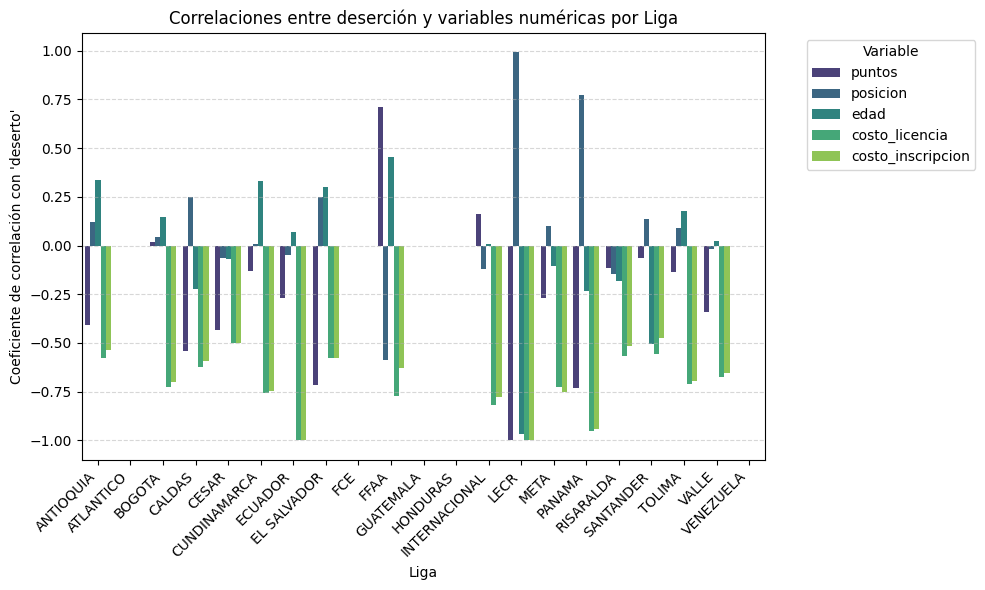

In [ ]:
# === 12. Análisis por LIGA ===
print("\n" + "="*60)
print("=== ANÁLISIS POR LIGA ===")

resultados_liga = []

for liga, datos_liga in df.groupby('liga'):
    print(f"\n=== Liga: {liga.upper()} ===")

    max_año = datos_liga['año'].max()
    ultima_por_deportista = datos_liga.groupby('nombre')['año'].max().reset_index()
    ultima_por_deportista['deserto'] = (max_año - ultima_por_deportista['año']) >= 1

    perfil = datos_liga.groupby('nombre').agg({
        'puntos': 'mean',
        'posicion': 'mean',
        'prueba_id': 'count',
        'categoria': 'first',
        'genero': 'first',
        'fecha_nacimiento': 'first',
        'costo_licencia': 'mean',
        'costo_inscripcion': 'mean',
        'edad': 'mean'
    }).reset_index()

    analisis_liga = perfil.merge(ultima_por_deportista[['nombre', 'año', 'deserto']], on='nombre')

    # === Métricas clave por liga ===
    tasa = analisis_liga['deserto'].mean()
    edad_prom_des = analisis_liga.loc[analisis_liga['deserto'], 'edad'].mean()
    costo_prom_lic = analisis_liga['costo_licencia'].mean()
    costo_prom_insc = analisis_liga['costo_inscripcion'].mean()

    print(f"Tasa de deserción en {liga}: {tasa:.2%}")
    print(f"Edad promedio de deserción: {edad_prom_des:.1f} años")
    print(f"Costo promedio (Licencia + Inscripción): ${costo_prom_lic + costo_prom_insc:,.0f}")
    print("Deserción por género:\n", analisis_liga.groupby('genero')['deserto'].mean(), "\n")

    resultados_liga.append(analisis_liga.assign(liga=liga))

# === 12.1. Resultados combinados por liga ===
analisis_total_liga = pd.concat(resultados_liga, ignore_index=True)

# === 12.2. Tasa de deserción por liga ===
tasa_por_liga = analisis_total_liga.groupby('liga')['deserto'].mean().reset_index().sort_values('deserto', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=tasa_por_liga, x='liga', y='deserto', palette='crest')
plt.title('Tasa de deserción por Liga (%)')
plt.ylabel('Porcentaje de desertores')
plt.xlabel('Liga')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === 12.3. Correlaciones entre deserción y variables numéricas por Liga ===
def calcular_corr(df):
    corr = df[['puntos', 'posicion', 'edad', 'costo_licencia', 'costo_inscripcion', 'deserto']].corr()['deserto']
    corr = corr.drop('deserto', errors='ignore')
    return corr

# Calculamos las correlaciones y las convertimos en tabla
corrs_liga = (
    analisis_total_liga.groupby('liga')
    .apply(calcular_corr)
    .reset_index()
    .melt(id_vars='liga', var_name='variable', value_name='correlacion')
)

# Revisamos que haya datos válidos
print("\nVista previa de las correlaciones por liga:")
print(corrs_liga.head())

# === Gráfico de correlaciones ===
plt.figure(figsize=(10,6))
sns.barplot(data=corrs_liga, x='liga', y='correlacion', hue='variable', palette='viridis')
plt.title("Correlaciones entre deserción y variables numéricas por Liga")
plt.xlabel("Liga")
plt.ylabel("Coeficiente de correlación con 'deserto'")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
from google.cloud import bigquery

# Crear cliente
client = bigquery.Client()

# Nombre de la tabla de salida
table_id = "instant-bonbon-474722-g7.Resultados_Pruebas_Mayores.Analisis_Desercion"

# Cargar dataframe a BigQuery
job = client.load_table_from_dataframe(analisis_total, table_id)
job.result()  # Esperar a que termine
print("✅ Tabla exportada a BigQuery:", table_id)


✅ Tabla exportada a BigQuery: instant-bonbon-474722-g7.Resultados_Pruebas_Mayores.Analisis_Desercion
